In [ ]:
%matplotlib inline
from pylab import *

In [ ]:
from defs_2024_05_11 import *

Splikes version  0.1.4
Plasticnet version  0.1.12
macOS-14.5-arm64-arm-64bit
Base Image File: asdf/bbsk081604_all_scale2.asdf


In [ ]:
base_sim_dir="sims-2024-05-26"
if not os.path.exists(base_sim_dir):
    os.mkdir(base_sim_dir)

In [ ]:
def default_post(number_of_neurons):
    post=pn.neurons.linear_neuron(number_of_neurons)
    post+=pn.neurons.process.sigmoid(0,50)
    return post

def default_bcm(pre,post,orthogonalization=True):
    c=pn.connections.BCM(pre,post,[-.01,.01],[.1,.2])
    
    if orthogonalization:
        c+=pn.connections.process.orthogonalization(10*minute)

    c.eta=2e-6
    c.tau=15*pn.minute   

    return c

## trying deficit with smaller amount of time

In [ ]:
def deficit(blur=[2.5,-1],noise=[0.1,0.1],rf_size=19,
            eta=2e-6,
           number_of_neurons=10,
           total_time=4*day,
           save_interval=1*hour):

    
    
    im=[]
    for b in blur:
        if b<0:
            im+=[pi5.filtered_images(base_image_file,
                                    {'type':'norm'},
                                    {'type':'dog','sd1':1,'sd2':3},   
                                    verbose=False,
                                    )
                ]
        else:
            im+=[pi5.filtered_images(base_image_file,
                                    {'type':'blur','size':b},
                                    {'type':'norm'},
                                    {'type':'dog','sd1':1,'sd2':3},   
                                    verbose=False,
                                    )
                ]
    pre1=pn.neurons.natural_images(im[0],
                                   rf_size=rf_size,verbose=False)

    pre2=pn.neurons.natural_images(im[1],rf_size=rf_size,
                                other_channel=pre1,
                                verbose=False)

    pre1+=pn.neurons.process.add_noise_normal(0,noise[0])

    sigma=noise
    pre2+=pn.neurons.process.add_noise_normal(0,noise[1])

    pre=pre1+pre2

    post=default_post(number_of_neurons)
    c=default_bcm(pre,post)
    c.eta=eta

    sim=pn.simulation(total_time)
    sim.dt=200*ms

    sim.monitor(post,['output'],save_interval)
    sim.monitor(c,['weights','theta'],save_interval)

    sim+=pn.grating_response(print_time=False)

    return sim,[pre,post],[c]


In [ ]:
def run_one_deficit(params,run=True,overwrite=False):
    import plasticnet as pn
    count,eta,blur,number_of_neurons,sfname=(params.count,params.eta,params.blur,
                                        params.number_of_neurons,params.sfname)
    
    if not overwrite and os.path.exists(sfname):
        return sfname
    
    seq=pn.Sequence()
    # deliberately use a standard deficit, with it's own eta and noise
    seq+=deficit(blur=blur,number_of_neurons=params.number_of_neurons) 

    if run:
        seq.run(display_hash=False)
        pn.save(sfname,seq) 
    
    return sfname
    

In [ ]:
number_of_neurons=20
eta=1e-6
number_of_processes=8
ray.init(num_cpus=number_of_processes)

2024-05-26 10:10:18,668	INFO worker.py:1749 -- Started a local Ray instance.


Python version:,3.11.8
Ray version:,2.20.0


In [ ]:
func=run_one_deficit
blur=2.5
sfname=f'{base_sim_dir}/deficit {number_of_neurons} neurons blur {blur:.1f}.asdf'

p=Struct()
p.eta=eta
p.number_of_neurons=number_of_neurons
p.sfname=sfname

p.blur=(blur,-1)
params=to_named_tuple([p])[0]

In [ ]:
params

params(eta=1e-06, number_of_neurons=20, sfname='sims-2024-05-26/deficit 20 neurons blur 2.5.asdf', blur=(2.5, -1), count=0)

In [ ]:
func(params,run=True,overwrite=True)

[.] Sequence Time Elapsed...3 m, 20.05 s


'sims-2024-05-26/deficit 20 neurons blur 2.5.asdf'

In [ ]:
R=Results(params.sfname)
strong_i=1
weak_i=0

sims-2024-05-26/deficit 20 neurons blur 2.5.asdf


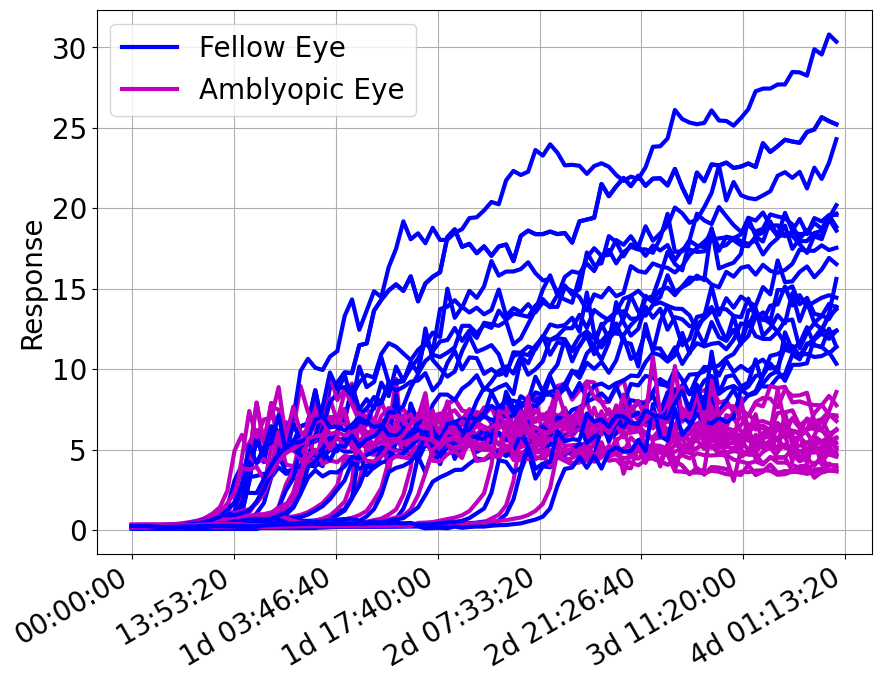

In [ ]:
plot(R.t,R.y[:,0,strong_i],'b',label='Fellow Eye')
plot(R.t,R.y[:,0,weak_i],'m',label='Amblyopic Eye')

for n in range(number_of_neurons):
    plot(R.t,R.y[:,n,0],'m')
    plot(R.t,R.y[:,n,1],'b')
    
    
ylabel('Response')
legend()
print(sfname)
reformat_time_axis()    

In [ ]:
def contrast_treatment(contrast=[1,1],noise=[0.1,0.1],
              rf_size=19,eta=5e-6,
           number_of_neurons=20,
           total_time=8*day,
           save_interval=1*hour):
    
        
    im=[]
    
    im+=[pi5.filtered_images(base_image_file,
                            {'type':'norm'},
                            {'type':'dog','sd1':1,'sd2':3},   
                            verbose=False,
                            )
                ]
    im+=[pi5.filtered_images(base_image_file,
                            {'type':'norm'},
                            {'type':'dog','sd1':1,'sd2':3},   
                            verbose=False,
                            )
                ]
 
        
    pre1=pn.neurons.natural_images(im[0],
                                   rf_size=rf_size,verbose=False)

    pre2=pn.neurons.natural_images(im[1],rf_size=rf_size,
                                other_channel=pre1,
                                verbose=False)

    
    for c,n,p in zip(contrast,noise,[pre1,pre2]):
        if c!=1:
            p+=pn.neurons.process.scale_shift(c,0)
        p+=pn.neurons.process.add_noise_normal(0,n)
        

    pre=pre1+pre2

    post=pn.neurons.linear_neuron(number_of_neurons)
    post+=pn.neurons.process.sigmoid(-1,50)

    c=pn.connections.BCM(pre,post,[-.1,.1],[.1,.2])
    c.eta=eta
    c.tau=100*second

    save_interval=save_interval

    sim=pn.simulation(total_time)

    sim.dt=200*ms

    sim.monitor(post,['output'],save_interval)
    sim.monitor(c,['weights','theta'],save_interval)

    sim+=pn.grating_response(print_time=False)

    return sim,[pre,post],[c]


    


@ray.remote
def run_one_contrast(params,run=True,overwrite=False):
    import plasticnet as pn
    count,eta,contrast,number_of_neurons,sfname=(params.count,params.eta,params.contrast,
                                        params.number_of_neurons,params.sfname)
    
    if not overwrite and os.path.exists(sfname):
        return sfname

    
    seq=pn.Sequence()
    # deliberately use a standard deficit, with it's own eta and noise
    seq+=deficit(number_of_neurons=params.number_of_neurons) 

    seq+=contrast_treatment(number_of_neurons=number_of_neurons,
                   contrast=contrast,
                   total_time=100*hour,
                   eta=eta,
                   save_interval=20*minute)

    if run:
        seq.run(display_hash=False,print_time=True)
        pn.save(sfname,seq) 

    
    return sfname
    
    

In [ ]:
linspace(0,1,21)

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [ ]:
func=run_one_contrast
contrast_mat=linspace(0,1,21)

all_params=[]
for c,contrast in enumerate(contrast_mat):

    sfname=f'{base_sim_dir}/contrast {number_of_neurons} neurons contrast {contrast:.2f}.asdf'

    p=Struct()
    p.eta=eta
    p.number_of_neurons=number_of_neurons
    p.sfname=sfname

    p.contrast=(1,contrast)
    all_params+=[p]

all_params=to_named_tuple(all_params)  

In [ ]:
### premake the images
for params in tqdm(all_params):
    result=func.remote(params,run=False,overwrite=True)
    sfname=ray.get(result)
    print(sfname)

  0%|          | 0/21 [00:00<?, ?it/s]

(pid=29947) Splikes version  0.1.4
(pid=29947) Plasticnet version  0.1.12
sims-2024-05-26/contrast 20 neurons contrast 0.00.asdf
sims-2024-05-26/contrast 20 neurons contrast 0.05.asdf
sims-2024-05-26/contrast 20 neurons contrast 0.10.asdf
sims-2024-05-26/contrast 20 neurons contrast 0.15.asdf
sims-2024-05-26/contrast 20 neurons contrast 0.20.asdf
sims-2024-05-26/contrast 20 neurons contrast 0.25.asdf
sims-2024-05-26/contrast 20 neurons contrast 0.30.asdf
sims-2024-05-26/contrast 20 neurons contrast 0.35.asdf
sims-2024-05-26/contrast 20 neurons contrast 0.40.asdf
sims-2024-05-26/contrast 20 neurons contrast 0.45.asdf
sims-2024-05-26/contrast 20 neurons contrast 0.50.asdf
sims-2024-05-26/contrast 20 neurons contrast 0.55.asdf
sims-2024-05-26/contrast 20 neurons contrast 0.60.asdf
sims-2024-05-26/contrast 20 neurons contrast 0.65.asdf
sims-2024-05-26/contrast 20 neurons contrast 0.70.asdf
sims-2024-05-26/contrast 20 neurons contrast 0.75.asdf
sims-2024-05-26/contrast 20 neurons contrast 0

In [ ]:
do_params=make_do_params(all_params,verbose=True)

21 sims
[params(eta=1e-06, number_of_neurons=20, sfname='sims-2024-05-26/contrast 20 neurons contrast 0.00.asdf', contrast=(1, 0.0), count=0), params(eta=1e-06, number_of_neurons=20, sfname='sims-2024-05-26/contrast 20 neurons contrast 0.05.asdf', contrast=(1, 0.05), count=1), params(eta=1e-06, number_of_neurons=20, sfname='sims-2024-05-26/contrast 20 neurons contrast 0.10.asdf', contrast=(1, 0.1), count=2), params(eta=1e-06, number_of_neurons=20, sfname='sims-2024-05-26/contrast 20 neurons contrast 0.15.asdf', contrast=(1, 0.15000000000000002), count=3), params(eta=1e-06, number_of_neurons=20, sfname='sims-2024-05-26/contrast 20 neurons contrast 0.20.asdf', contrast=(1, 0.2), count=4)] ... [params(eta=1e-06, number_of_neurons=20, sfname='sims-2024-05-26/contrast 20 neurons contrast 0.80.asdf', contrast=(1, 0.8), count=16), params(eta=1e-06, number_of_neurons=20, sfname='sims-2024-05-26/contrast 20 neurons contrast 0.85.asdf', contrast=(1, 0.8500000000000001), count=17), params(eta=1e-

In [ ]:
results = [func.remote(p) for p in do_params]
sfnames=ray.get(results)

(run_one_contrast pid=29947) [
(pid=29941) Splikes version  0.1.4
(pid=29941) Plasticnet version  0.1.12
(run_one_contrast pid=29947) .
(run_one_contrast pid=29943) [ [repeated 7x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(pid=29943) Splikes version  0.1.4 [repeated 6x across cluster]
(pid=29943) Plasticnet version  0.1.12 [repeated 6x across cluster]
(run_one_contrast pid=29947) .] Sequence Time Elapsed...1 m, 57.18 s
(run_one_contrast pid=29945) . [repeated 7x across cluster]
(run_one_contrast pid=29947) [
(run_one_contrast pid=29943) .] Sequence Time Elapsed...1 m, 58.85 s [repeated 7x across cluster]
(run_one_contrast pid=29947) .
(run_one_contrast pid=29943) [ [repeated 7x across cluster]
(run_one_contrast pid=29947) .] Sequence Time Elapsed...1 m, 56.19 s
(run_one_contrast pid=29943) . [repeated 

In [ ]:
S=Storage()
for params in tqdm(all_params):
    sfname=params.sfname
    contrast=params.contrast[1]
    
    R=Results(sfname)

    
    idx1,idx2=[_[1] for _ in R.sequence_index]
    t=R.t/day
    recovery_rate_μ,recovery_rate_σ=μσ((R.ODI[idx2,:]-R.ODI[idx1,:])/(t[idx2]-t[idx1]))  
    
    S+=contrast,recovery_rate_μ,recovery_rate_σ    
        
contrast,recovery_rate_μ,recovery_rate_σ=S.arrays()

contrast_result=contrast,recovery_rate_μ,recovery_rate_σ


  0%|          | 0/21 [00:00<?, ?it/s]

Text(0.5, 0, 'Contrast')

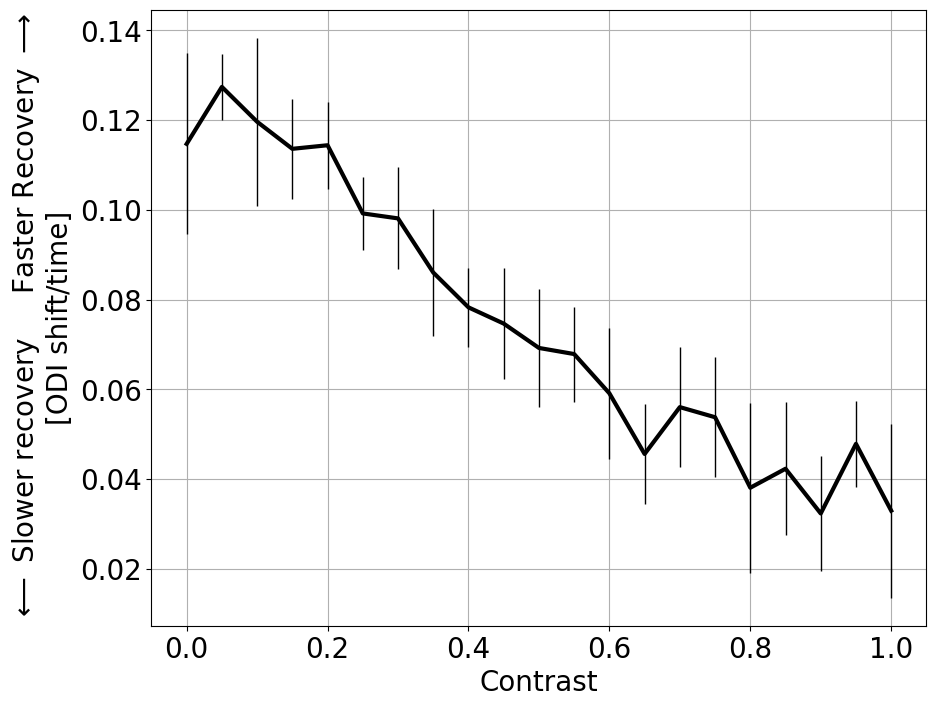

In [ ]:
errorbar(contrast,-recovery_rate_μ,yerr=2*recovery_rate_σ,elinewidth=1,color='k',label='No Mask') # positive = recovery

ylabel(r'$\longleftarrow$ Slower recovery     Faster Recovery $\longrightarrow$'+"\n[ODI shift/time]")

xlabel('Contrast')


### With 8 days of deficit

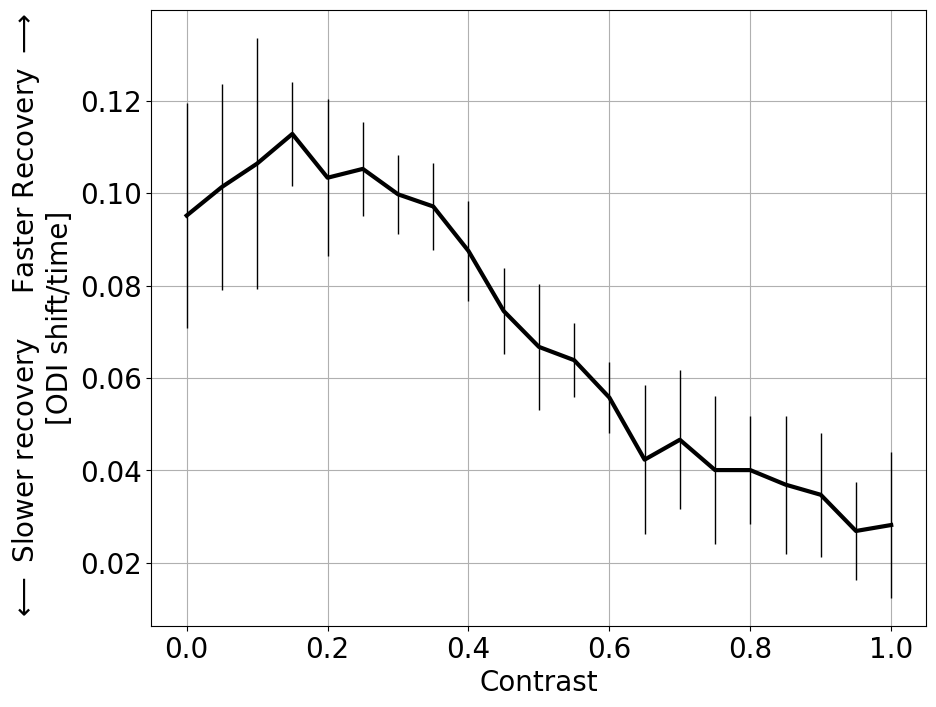

In [ ]:
params=all_params[10]
params

params(eta=1e-06, number_of_neurons=20, sfname='sims-2024-05-26/contrast 20 neurons contrast 0.50.asdf', contrast=(1, 0.5), count=10)

-0.06921522778915214
sims-2024-05-26/contrast 20 neurons contrast 1.00.asdf


<matplotlib.collections.LineCollection>

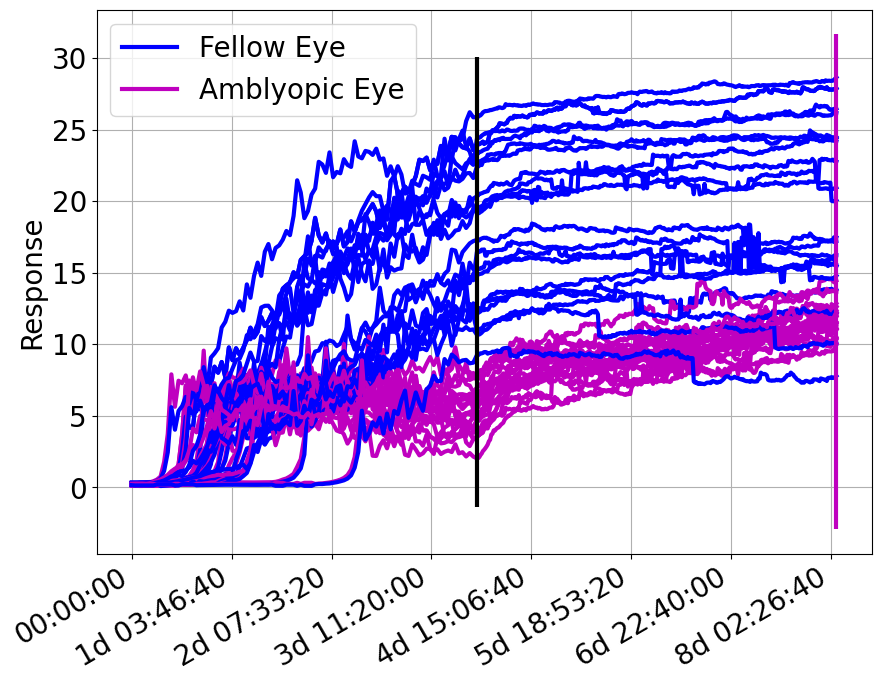

In [ ]:
R=Results(params.sfname)

idx1,idx2=[_[1] for _ in R.sequence_index]
t=R.t/day
recovery_rate_μ,recovery_rate_σ=μσ((R.ODI[idx2,:]-R.ODI[idx1,:])/(t[idx2]-t[idx1]))  
print(recovery_rate_μ)


plot(R.t,R.y[:,0,strong_i],'b',label='Fellow Eye')
plot(R.t,R.y[:,0,weak_i],'m',label='Amblyopic Eye')

for n in range(number_of_neurons):
    plot(R.t,R.y[:,n,0],'m')
    plot(R.t,R.y[:,n,1],'b')
    
    
ylabel('Response')
legend()
print(sfname)
reformat_time_axis()  


vlines(R.t[idx1],*ylim(),color='k')
vlines(R.t[idx2],*ylim(),color='m')


In [ ]:
R.sequence_index

[(0, 96), (97, 397)]

In [ ]:
idx1

96

In [ ]:
R.ODI.shape

(398, 20)

sims-2024-05-26/contrast 20 neurons contrast 1.00.asdf


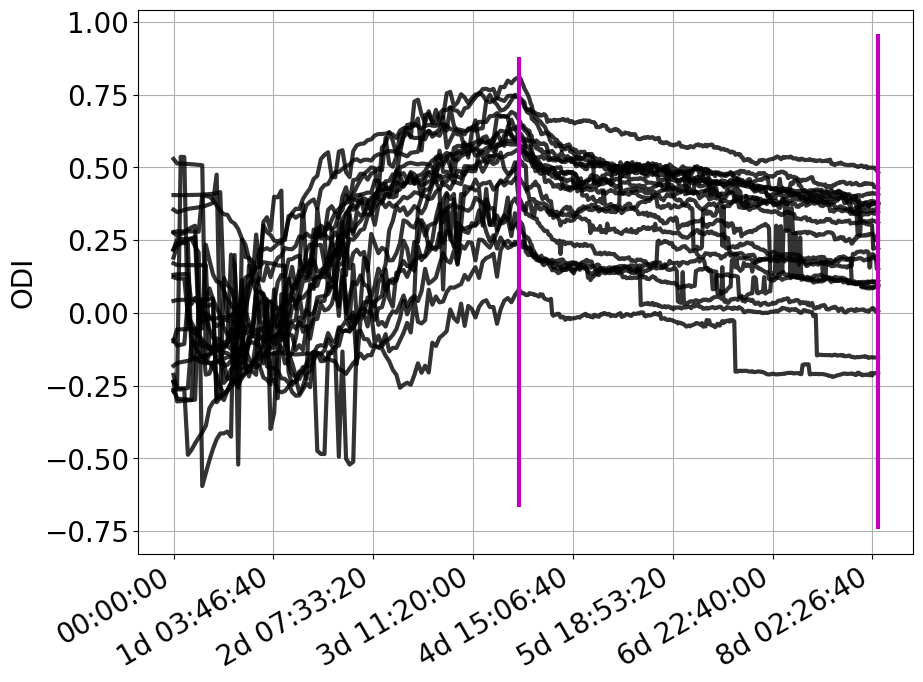

In [ ]:
R=Results(params.sfname)
for n in range(number_of_neurons):
    plot(R.t,R.ODI[:,n],'k',alpha=0.8)
        
        
vlines(R.t[idx1],*ylim(),color='m')
vlines(R.t[idx2],*ylim(),color='m')
        
ylabel('ODI')
print(sfname)
reformat_time_axis()    